In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [21]:
class AdalineGD:
    """ADAptive Linear NEutron分類器

    eta:学習率
    n_iter：訓練回数
    random_state：乱数シード
    
    w_：重みベクトル　1次元配列
    b_：バイアスユニット スカラー
    losses：各エポックでのMSE"""
    def __init__(self, eta = 0.01, n_iter = 50, random_state = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """訓練データに適合させる
        X：shape = [n_examples, n_features]
        y：shape = [n_examples]
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    def activation(self, X):
        return X
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [17]:
s = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(s, header = None, encoding = "utf-8")
y = df.iloc[0:100,4].values
y = np.where(y == "Iris-setosa", 0,1)
X = df.iloc[0:100, [0,2]].values

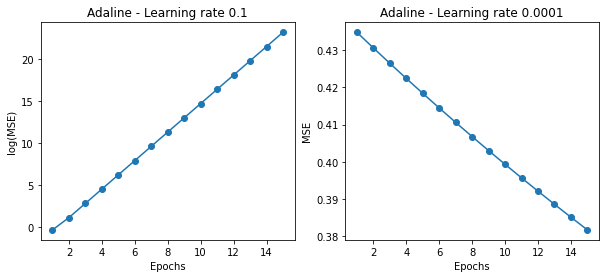

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), np.log10(ada1.losses_), marker="o")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log(MSE)")
ax[0].set_title("Adaline - Learning rate 0.1")
ada2 = AdalineGD(n_iter=15, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker="o")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("MSE")
ax[1].set_title("Adaline - Learning rate 0.0001")
plt.show()

学習率が大きすぎる・・・ステップが極小値を通り過ぎていつまでも収束しない
学習率が小さすぎる・・・収束に必要なエポック数が大きくなる
→データを標準化する

In [24]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

In [25]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

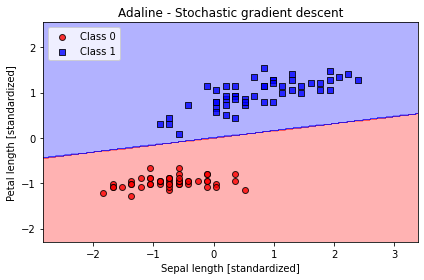

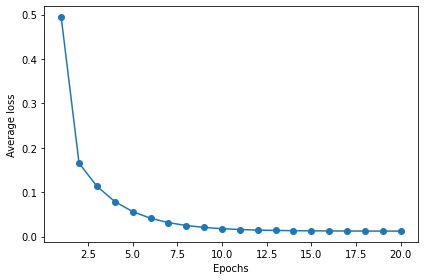

In [29]:
ada_sgd = AdalineGD(n_iter = 20, eta = 0.5)
ada_sgd.fit(X_std,y)
plot_decision_regions(X_std, y, classifier = ada_sgd)
plt.title("Adaline - Stochastic gradient descent")
plt.xlabel("Sepal length [standardized]")
plt.ylabel("Petal length [standardized]")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Average loss")
plt.tight_layout()
plt.show()

In [44]:
class AdalineSGD:
    """ADAptive Linear NEutron分類器

    eta:学習率
    n_iter：訓練回数
    random_state：乱数シード
    
    w_：重みベクトル　1次元配列
    b_：バイアスユニット スカラー
    losses：各エポックでのMSE"""
    def __init__(self, eta = 0.01, n_iter = 10,shuffle = True, random_state = None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False #重みの初期化フラグ
        self.shuffle = shuffle     #各エポックで訓練データをシャッフルするか
        self.random_state = random_state
        
    def fit(self, X, y):
        """訓練データに適合させる
        X：shape = [n_examples, n_features]
        y：shape = [n_examples]
        """
        self._initialize_weights(X.shape[1]) #重みベクトルの生成
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle: #訓練データのシャッフル
                X, y =self._shuffle(X,y)
            losses = []
            for xi, target in zip(X,y):
                #特徴量xiと目的変数yを使った重みの更新と損失値の計算
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1: #yの要素数が2以上なら各訓練データの特徴量と目的変数targetで重みを更新
            for xi, target in zip(X,y):
                self._update_weights(xi, target)
        else: #yの要素数が1なら全体データの特徴量と目的変数yで重みを更新
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m): #重みを乱数で初期化
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc= 0.0, scale = 0.01, size = m)
        self.b_ = np.float_(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target): #ADALINEの学習規則で重みを更新
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * error
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

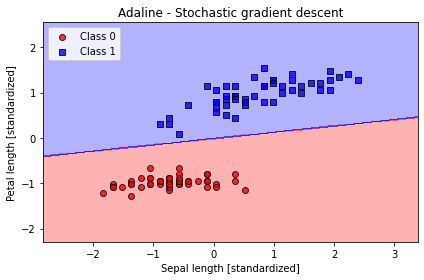

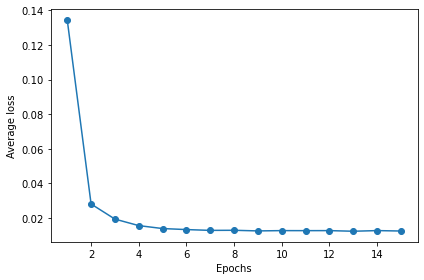

In [49]:
ada_sgd = AdalineSGD(n_iter = 15, eta = 0.01, random_state = 1)
ada_sgd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier = ada_sgd)
plt.title("Adaline - Stochastic gradient descent")
plt.xlabel("Sepal length [standardized]")
plt.ylabel("Petal length [standardized]")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Average loss")
plt.tight_layout()
plt.show()